## Step B

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import skimage.morphology as sk
from operator import itemgetter
import os

The ```compute_all_keypoints``` function calculates all keypoints of all query and train images and stores them in a dictionary, in order to easily access them later.

In [23]:
def compute_all_keypoints(query_imgs, train_imgs, sift):

    img_dict = {}

    for img in query_imgs:
        file = 'images/models/' + img + '.jpg'
        query = cv2.imread(file, 0)
        kp, des = sift.detectAndCompute(query, None)
        img_dict[img] = {'kp': kp, 'des': des, 'shape': query.shape}

    for img in train_imgs:
        file = 'images/scenes/' + img + '.png'
        train = cv2.imread(file, 0)
        kp, des = sift.detectAndCompute(train, None)
        img_dict[img] = {'kp': kp, 'des': des, 'shape': train.shape}

    return img_dict

The ```apply_ratio_test``` function takes all the matches found between the query and the train image, it chooses the good ones with the usual ratio test and it stores them in a dictionary using the indexes of the query keypoints as keys and the indexes of the train keypoints as values.

In [24]:
def apply_ratio_test(all_matches):

    # map of matches kp_train_idx -> kp_query_idx
    good_matches = {}

    for m, n in all_matches:
        if m.distance < LOWE_COEFF * n.distance:
            good_matches[m.queryIdx] = m.trainIdx
      
    return good_matches

The ```compute_entry_hough_space``` function maps a point into the 4-dimensional Hough space, the ```create_hough_space``` function computes the Hough space entries for all keypoints.

In [25]:
def compute_entry_hough_space(kp_q, kp_t, q_xc, q_yc):

    entry = {}

    v = ((q_xc - kp_q.pt[0]), (q_yc - kp_q.pt[1]))
    scale_ratio = kp_t.size / kp_q.size
    delta_angle = kp_t.angle - kp_q.angle
    x_c = kp_t.pt[0] + scale_ratio * (np.cos(delta_angle) * v[0] - np.sin(delta_angle) * v[1])
    y_c = kp_t.pt[1] + scale_ratio * (np.sin(delta_angle) * v[0] + np.cos(delta_angle) * v[1])

    entry['x_c'] = x_c
    entry['y_c'] = y_c
    entry['scale_ratio'] = scale_ratio
    entry['delta_angle'] = delta_angle
    
    return entry 

In [26]:
def create_hough_space(good_matches, kp_query, kp_train, query_xc, query_yc):
    
    # map of hough space kp_train_idx -> map name-values
    hough_space = {}

    for t_idx, q_idx in good_matches.items():
        hough_space[t_idx] = compute_entry_hough_space(kp_query[q_idx], kp_train[t_idx], query_xc, query_yc)
    
    return hough_space

The ```compute_bins``` function partitions the 4-dimensional Hough space into discrete bins.

In [27]:
def compute_bins(hough_space,query_shape,train_shape):

    values = {}
    
    data_scale = [entry['scale_ratio'] for entry in hough_space.values()]
    counts_scale, bins_scale, patches_size = plt.hist(data_scale, bins='auto')
    img_scale = np.mean([bins_scale[np.argmax(counts_scale)], bins_scale[np.argmax(counts_scale) + 1]])
    plt.close();

    data_angle = [entry['delta_angle'] for entry in hough_space.values()]
    counts_angle, bins_angle, patches_angle = plt.hist(data_angle, bins='auto')
    plt.close();

    x_bin_size = img_scale * query_shape[1] * BIN_PRECISION_FACTOR
    y_bin_size = img_scale * query_shape[0] * BIN_PRECISION_FACTOR
    x_bins = int(np.ceil(train_shape[1] / x_bin_size) + 2)
    y_bins = int(np.ceil(train_shape[0] / y_bin_size) + 2)
    x_min = train_shape[1] / 2 - x_bins / 2 * x_bin_size
    y_min = train_shape[0] / 2 - y_bins / 2 * y_bin_size

    angle_bin_size = np.std(data_angle) * ANGLE_BIN_SIZE_COEFF
    angle_bin_center = np.mean(data_angle)
    angle_min = angle_bin_center - ANGLE_BINS / 2 * angle_bin_size
    angle_max = angle_bin_center + ANGLE_BINS / 2 * angle_bin_size

    scale_bin_size = np.std(data_scale) * SCALE_BIN_SIZE_COEFF
    scale_bin_center = np.mean(data_scale)
    scale_min = 0 
    scale_max = scale_bin_center * 2 
    scale_bins = int((scale_max - scale_min) / scale_bin_size)

    values['x_bins'] = x_bins
    values['y_bins'] = y_bins
    values['x_min'] = x_min
    values['y_min'] = y_min
    values['x_bin_size'] = x_bin_size
    values['y_bin_size'] = y_bin_size
    values['scale_bins'] = scale_bins
    values['scale_min'] = scale_min
    values['scale_bin_size'] = scale_bin_size
    values['angle_min'] = angle_min
    values['angle_bin_size'] = angle_bin_size  

    return values

The ```voting``` function attributes 16 bins to each point in the 4-dimensional Hough space.

In [28]:
def voting(b,h_s):

    accumulator = np.zeros((b['x_bins'], b['y_bins'], ANGLE_BINS, b['scale_bins']))

    votes = {}

    for idx, v in h_s.items():
        try:
            for x in range(0, 2):
                for y in range(0, 2):
                    for z in range(0, 2):
                        for w in range(0, 2):                
                            i = int(np.floor((v['x_c'] - b['x_min'] + (x - 1 / 2) * b['x_bin_size']) / b['x_bin_size']))
                            j = int(np.floor((v['y_c'] - b['y_min'] + (y - 1 / 2) * b['y_bin_size']) / b['y_bin_size']))
                            k = int(np.floor((v['delta_angle'] - b['angle_min'] + (z - 1 / 2) * b['angle_bin_size']) / b['angle_bin_size']))
                            l = int(np.floor((v['scale_ratio'] - b['scale_min'] + (w - 1 / 2) * b['scale_bin_size']) / b['scale_bin_size']))
                            if i >= 0 and j >= 0 and k >= 0 and l >= 0:
                                accumulator[i, j, k, l] += 1
                                votes[(i, j, k, l)] = votes.get((i, j, k, l), [])
                                votes[(i, j, k, l)].append(idx)
        except: pass
    
    return accumulator, votes   

The ```find_all_correspondeces``` function computes all the correspondeces between query points and train points that voted for a local maxima.

In [29]:
def find_all_correspondeces(query_imgs, train_img, img_dict, bf):

    # list of lists of all correspondent point of every image  
    global_correspondences = []

    for query_img in query_imgs:
        
        # compute keypoints and desctiptors for query and train
        kp_query, des_query = img_dict[query_img]['kp'], img_dict[query_img]['des']
        kp_train, des_train = img_dict[train_img]['kp'], img_dict[train_img]['des']

        # match descriptors between the two images 
        all_matches = bf.knnMatch(des_train, des_query, k=2)

        # create map of matching keypoint indexes surviving the lowe ratio test 
        good_matches = apply_ratio_test(all_matches)

        # barycenter of found query keypoint 
        query_xc = np.mean(list(kp_query[p].pt[0] for _, p in good_matches.items()))
        query_yc = np.mean(list(kp_query[p].pt[1] for _, p in good_matches.items()))

        # create hough space 
        hough_space = create_hough_space(good_matches, kp_query, kp_train, query_xc, query_yc)

        # do not go on with this query image if the number of entries in the hough space are below a certain threshold
        if len(hough_space) < HOUGH_T: continue

        # compute all the values related to the size 
        bins_values = compute_bins(hough_space, img_dict[query_img]['shape'], img_dict[train_img]['shape'])

        # create and populate accumulator with voting by each entry of the hough space 
        accumulator, votes= voting(bins_values, hough_space)

        # compute local maxima of the 4-dimensional accumulator 
        mask = sk.local_maxima(accumulator)
        accumulator[mask != 1] = 0

        # store in a list all the correspondeces between query points and train points that voted for a local maxima 
        # the list contains: number of votes that a local maxima bin has received, name of query image, list of query and train keypoints which voted for that bin
        for b in list(np.argwhere(accumulator >= T_Q)): # thresholding the accumulator to come up with few maxima 
            keypoint_index_list = votes[tuple(b)] # all query keypoint who voted for a local maxima bin 
            correspondence_list = [(kp_train[k], kp_query[good_matches[k]]) for k in keypoint_index_list]
            global_correspondences.append([accumulator[tuple(b)], query_img, correspondence_list])

    # sorted correspondences based on number of votes found in local maxima bins 
    g_c = sorted(global_correspondences, key=itemgetter(0), reverse=True)

    return g_c 

The ```check_matches``` function orders the good matches in decreasing number of keypoints and it runs a series of tests on them, checking the geometric arrangement and the color consistency.

In [30]:
def check_matches(correspondences, train_img):

    train_file = 'images/scenes/' + train_img + '.png'
    train_bgr = cv2.imread(train_file)

    #dict query_name -> list of projected query vertex into train image
    recognised = {}

    for entry in correspondences:
        try:

            query_file = 'images/models/' + entry[1] + '.jpg'
            query_bgr = cv2.imread(query_file)
            
            # compute homography through correspondent keypoints
            src_pts = np.float32([e[1].pt for e in entry[2]]).reshape(-1, 1, 2)
            dst_pts = np.float32([e[0].pt for e in entry[2]]).reshape(-1, 1, 2)
            M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            h, w, d = query_bgr.shape
            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts, M)

            # determine center of the train ROI matching with the image query
            center = tuple((dst[0, 0, i] + dst[1, 0, i] + dst[2, 0, i] + dst[3, 0, i]) / 4 for i in (0, 1))

            # determine extreme points of the quadrilateral shape of query image projected into train scene
            x_min = int(max((dst[0,0,0] + dst[1,0,0]) / 2, 0))
            y_min = int(max((dst[0,0,1] + dst[3,0,1]) / 2, 0))
            x_max = int(min((dst[2,0,0] + dst[3,0,0]) / 2, train_bgr.shape[1]))
            y_max = int(min((dst[1,0,1] + dst[2,0,1]) / 2, train_bgr.shape[0]))

            # compute main color of both query and train ROI to tell similar boxes apart
            query_color = query_bgr.mean(axis=0).mean(axis=0)
            train_crop = train_bgr[y_min:y_max, x_min:x_max]
            train_color = train_crop.mean(axis=0).mean(axis=0)   
            color_diff = np.sqrt(np.sum([value ** 2 for value in abs(query_color - train_color)]))
            
            # recognise a query in the scene only if its ROI color is similar to the query color and it does not overlap with another already placed box
            temp = True
            if color_diff < COLOR_T:
                for k, v in recognised.items():
                    for corners in v:
                        r_center = tuple((corners[0, 0, i] + corners[1, 0, i] + corners[2, 0, i] + corners[3, 0, i]) / 4 for i in (0, 1))
                        if (center[0] > min(corners[0, 0, 0], corners[1, 0, 0]) and center[0] < max(corners[2, 0, 0], corners[3, 0, 0])\
                            and center[1] > min(corners[0, 0, 1], corners[3, 0, 1]) and center[1] < max(corners[1, 0, 1], corners[2, 0, 1]))\
                            or (r_center[0] > x_min and r_center[0] < x_max\
                            and r_center[1] > y_min and r_center[1] < y_max):
                            temp = False
                            break
                if temp:
                    recognised[entry[1]] = recognised.get(entry[1], [])  
                    recognised[entry[1]].append(dst)
        except: pass
    
    return recognised

The ```print_matches``` function takes all the recognised images and prints their details, i.e. their position, width, and height.

In [31]:
def print_matches(train_img, query_imgs, recognised, true_imgs, verbose):
    
    print('Scene: ' + train_img + '\n')

    for query_img in query_imgs:
                     
        total = len(recognised.get(query_img, []))
        true_total = true_imgs[train_img][query_img]

        if total != true_total:
            print('\033[1m' + 'Product ' + query_img + ' – ' + str(total) + '/' + str(true_total) + ' instances found' + '\033[0m')
        elif total > 0 or verbose == True:
            print('Product ' + query_img + ' – ' + str(total) + '/' + str(true_total) + ' instances found')
            
        for j in range(total):
            dst = recognised[query_img][j]
            center = tuple(int((dst[0, 0, i] + dst[1, 0, i] + dst[2, 0, i] + dst[3, 0, i]) / 4) for i in (0, 1))
            w = int(((dst[3, 0, 0] - dst[0, 0, 0]) + (dst[2, 0, 0] - dst[1, 0, 0])) /2)
            h = int(((dst[1, 0, 1] - dst[0, 0, 1]) + (dst[2, 0, 1] - dst[3, 0, 1])) /2)
            print('\t' + 'Position: ' + str(center)\
                 + '\t' + 'Width: ' + str(w)\
                 + '\t' + 'Height: ' + str(h))

The ```draw_matches``` function draws on the train image the boxes' homographies and the numbers corresponding to the query images.

In [32]:
def draw_matches(recognised, train_img, color):

    train_file = 'images/scenes/' + train_img + '.png'

    # if color option is enabled all the results are printed on colored images 
    if color == True:
        train_bgr = cv2.imread(train_file)
        train_temp = cv2.cvtColor(train_bgr, cv2.COLOR_BGR2RGB)
        train_rgb = np.zeros(train_bgr.shape, train_bgr.dtype)
        for y in range(train_temp.shape[0]):
            for x in range(train_temp.shape[1]):
                for c in range(train_temp.shape[2]):
                    train_rgb[y, x, c] = np.clip(0.5 * train_temp[y, x, c], 0, 255)
    else:
        train_gray = cv2.imread(train_file, 0)
        train_rgb = cv2.cvtColor(train_gray // 2, cv2.COLOR_GRAY2RGB)

    # for each recognised box in the scene draw the bounding box with its number in it 
    for k, v in recognised.items():
        for dst in v:
            
            train_rgb = cv2.polylines(train_rgb, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(train_rgb, k,\
                        (int((dst[3, 0, 0] - dst[0, 0, 0]) * 0.25 + dst[0, 0, 0]), int((dst[1, 0, 1] - dst[0, 0, 1]) * 0.67 + dst[0, 0, 1])),\
                        font, 5, (0, 255, 0), 10, cv2.LINE_AA)        
           
    plt.imshow(train_rgb),plt.show();

    if color == True:
        
        if not os.path.exists('output/step_B/'):
            os.mkdir('output/step_B/')

        cv2.imwrite('output/step_B/' + train_img + '.png', cv2.cvtColor(train_rgb, cv2.COLOR_RGB2BGR))

The ```step_B``` function takes the lists of query and train images and performs the product recognition.

In [33]:
 def step_B(query_imgs, train_imgs, true_imgs, verbose, color):

    sift = cv2.SIFT_create()

    # descriptor matcher 
    bf = cv2.BFMatcher()

    img_dict = compute_all_keypoints(query_imgs, train_imgs, sift)    #compute all keypoints for all images once for all 

    for train_img in train_imgs:

        g_c = find_all_correspondeces(query_imgs, train_img, img_dict, bf)

        recognised = check_matches(g_c, train_img)
        
        print_matches(train_img, query_imgs, recognised, true_imgs, verbose)
            
        draw_matches(recognised, train_img, color)

        print('\n')

Parameters:

In [34]:
LOWE_COEFF = 0.8
BIN_PRECISION_FACTOR = 0.25
ANGLE_BINS = 7
ANGLE_BIN_SIZE_COEFF = 0.1
SCALE_BIN_SIZE_COEFF = 0.1
T_Q = 5
COLOR_T = 50
HOUGH_T = 100

In [35]:
query_imgs = ['0', '1', '11', '19', '24', '25', '26']
train_imgs = ['e1', 'e2', 'e3', 'e4', 'e5',\
              'm1', 'm2', 'm3', 'm4', 'm5']
true_imgs = {
    'e1': {'0': 1, '1': 0, '11': 1, '19': 0, '24': 0, '25': 0, '26': 0},
    'e2': {'0': 0, '1': 0, '11': 0, '19': 0, '24': 1, '25': 1, '26': 1},
    'e3': {'0': 1, '1': 1, '11': 1, '19': 0, '24': 0, '25': 0, '26': 0},
    'e4': {'0': 1, '1': 0, '11': 1, '19': 0, '24': 0, '25': 1, '26': 1},
    'e5': {'0': 0, '1': 0, '11': 0, '19': 1, '24': 0, '25': 1, '26': 0},
    'm1': {'0': 0, '1': 0, '11': 0, '19': 0, '24': 2, '25': 1, '26': 1},
    'm2': {'0': 1, '1': 2, '11': 1, '19': 0, '24': 0, '25': 0, '26': 0},
    'm3': {'0': 0, '1': 0, '11': 0, '19': 1, '24': 0, '25': 2, '26': 1},
    'm4': {'0': 0, '1': 0, '11': 0, '19': 0, '24': 2, '25': 2, '26': 1},
    'm5': {'0': 0, '1': 2, '11': 1, '19': 1, '24': 0, '25': 2, '26': 0},
}

Scene: e1

Product 0 – 1/1 instances found
	Position: (162, 214)	Width: 310	Height: 433
Product 11 – 1/1 instances found
	Position: (442, 170)	Width: 300	Height: 392


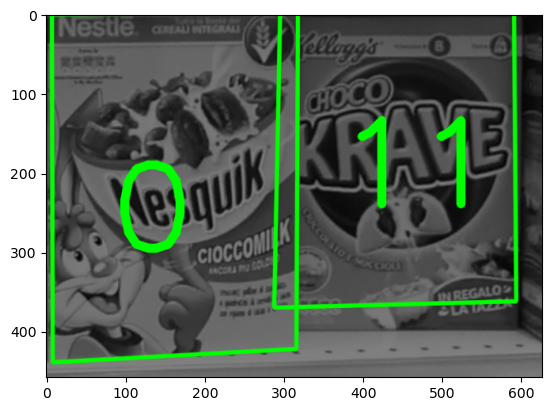


Scene: e2

Product 24 – 1/1 instances found
	Position: (167, 219)	Width: 334	Height: 489
Product 25 – 1/1 instances found
	Position: (877, 233)	Width: 313	Height: 442
Product 26 – 1/1 instances found
	Position: (538, 218)	Width: 332	Height: 486


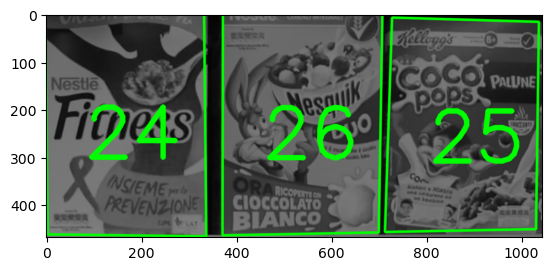


Scene: e3

Product 0 – 1/1 instances found
	Position: (171, 237)	Width: 324	Height: 439
Product 1 – 1/1 instances found
	Position: (817, 195)	Width: 305	Height: 405
Product 11 – 1/1 instances found
	Position: (477, 188)	Width: 304	Height: 395


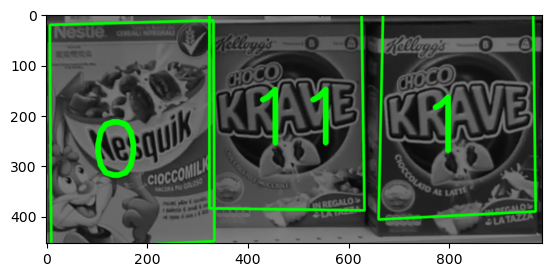


Scene: e4

Product 0 – 1/1 instances found
	Position: (158, 739)	Width: 325	Height: 439
Product 11 – 1/1 instances found
	Position: (464, 692)	Width: 303	Height: 394
Product 25 – 1/1 instances found
	Position: (555, 210)	Width: 324	Height: 452
Product 26 – 1/1 instances found
	Position: (205, 195)	Width: 340	Height: 493


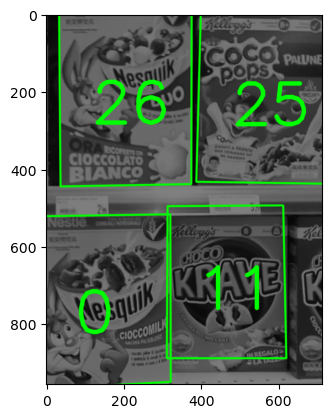


Scene: e5

Product 19 – 1/1 instances found
	Position: (502, 190)	Width: 295	Height: 384
Product 25 – 1/1 instances found
	Position: (160, 230)	Width: 322	Height: 449


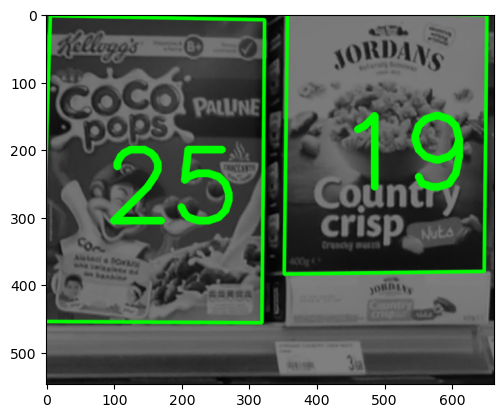


Scene: m1

Product 24 – 2/2 instances found
	Position: (185, 215)	Width: 350	Height: 497
	Position: (550, 218)	Width: 336	Height: 490
Product 25 – 1/1 instances found
	Position: (1261, 233)	Width: 313	Height: 442
Product 26 – 1/1 instances found
	Position: (921, 218)	Width: 333	Height: 486


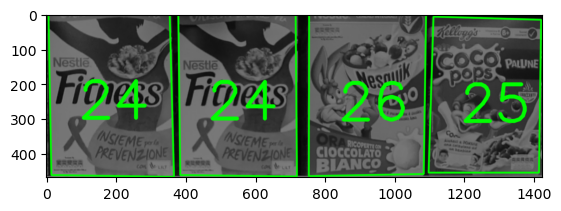


Scene: m2

Product 0 – 1/1 instances found
	Position: (178, 301)	Width: 343	Height: 449
Product 1 – 2/2 instances found
	Position: (848, 258)	Width: 313	Height: 410
	Position: (1180, 255)	Width: 302	Height: 406
Product 11 – 1/1 instances found
	Position: (510, 248)	Width: 308	Height: 401


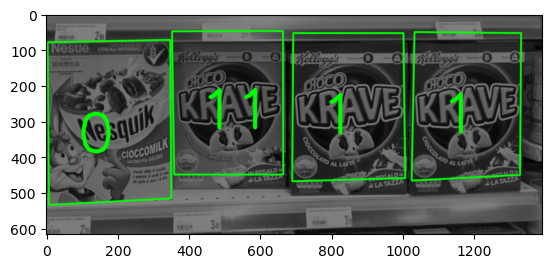


Scene: m3

Product 19 – 1/1 instances found
	Position: (1232, 190)	Width: 296	Height: 384
Product 25 – 2/2 instances found
	Position: (558, 222)	Width: 336	Height: 458
	Position: (889, 228)	Width: 321	Height: 445
Product 26 – 1/1 instances found
	Position: (195, 206)	Width: 353	Height: 506


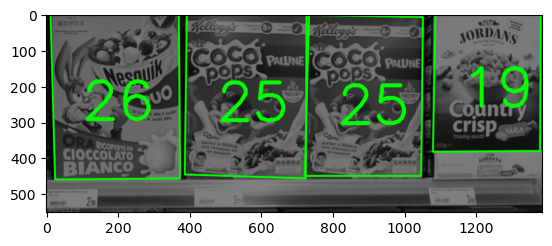


Scene: m4

Product 24 – 2/2 instances found
	Position: (160, 192)	Width: 362	Height: 508
	Position: (540, 196)	Width: 349	Height: 499
Product 25 – 2/2 instances found
	Position: (1270, 260)	Width: 354	Height: 544
	Position: (1590, 276)	Width: 342	Height: 555
Product 26 – 1/1 instances found
	Position: (922, 196)	Width: 339	Height: 493


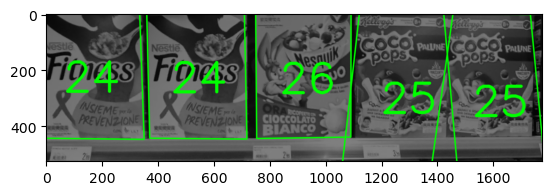


Scene: m5

Product 1 – 2/2 instances found
	Position: (500, 719)	Width: 313	Height: 410
	Position: (832, 715)	Width: 301	Height: 410
Product 11 – 1/1 instances found
	Position: (163, 716)	Width: 309	Height: 403
Product 19 – 1/1 instances found
	Position: (909, 190)	Width: 295	Height: 384
Product 25 – 2/2 instances found
	Position: (565, 230)	Width: 321	Height: 450
	Position: (235, 288)	Width: 373	Height: 576


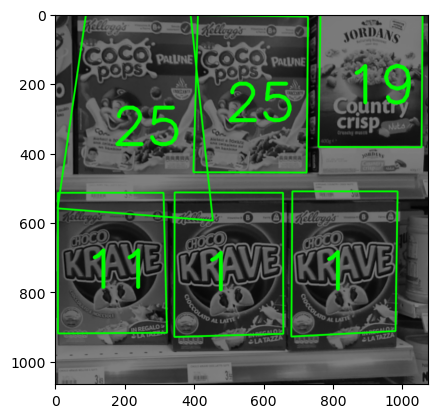

In [36]:
# verbose=False does not print the true negative instances
# color=True outputs all the scenes in color instead of grayscale and saves them, but the process is quite slow
step_B(query_imgs, train_imgs, true_imgs, verbose=False, color=False)